In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pylab as pl
from IPython import display

### Generate sample data, with added gaussian noise

In [3]:
W_true = [3,2,-3,-2,-11,5,-0.4,-3,9,3]
Number_of_points = 1000
Number_of_training = int(Number_of_points*0.8)
Number_of_testing = int(Number_of_points*0.2)

In [4]:
def generate_data():  
    X_data = np.linspace(0,1.2,Number_of_points)
    Y_data = np.sin(2*np.pi*X_data) + np.random.normal(0,0.3,Number_of_points)
    return X_data,Y_data

In [5]:
def split_data(X_data,Y_data):
    index = np.random.permutation(Number_of_points)
    
    X_train = X_data[index[:Number_of_training]] 
    Y_train = Y_data[index[:Number_of_training]]
    
    X_test = X_data[index[Number_of_training:]]
    Y_test = Y_data[index[Number_of_training:]]
    
    return X_train,Y_train,X_test,Y_test
    

In [6]:
import matplotlib.pyplot as plt
def plot(x,y,title):
    fig,(ax1) = plt.subplots(1)
    if title!='Loss':
        ax1.plot(x,y,'x')
    else:
        ax1.plot(x,y)
    ax1.set_title(title, fontdict={'fontsize': 15, 'fontweight': 'medium'})
    
def plot_curve(x,y,W,title,Order):
    fig,(ax1) = plt.subplots(1)
    ax1.plot(x,y)
    ax1.set_title(title, fontdict={'fontsize': 15, 'fontweight': 'medium'})
    y = np.zeros((x.shape[0],))
    for i in range(Order+1):
        y += W[i]*x**i
    ax1.plot(x,y)


def plot_map(mean,cov,X,like_precision,x=None,y=None,posterior=False):
    fig,ax1 = plt.subplots(1)
    ax1.set_xlim([0,1])
    ax1.set_ylim([-1,1])
    ax1.set_title('Randomly sampled lines', fontdict={'fontsize': 15, 'fontweight': 'medium'})
    Num_lines = 10
    W = np.random.multivariate_normal(mean, cov, Num_lines).T

    for i in range(Num_lines):
        Y = np.matmul(W[:,i].transpose(),X)
        ax1.plot(X_train,Y,'x',markersize=1,color = 'red')
    
    if posterior==True:
        ax1.plot(x,y,'o',markersize=5,color='green')

    



In [7]:
def fit(X_train,Y_train,Order,prior_mean,prior_cov,like_std,like_precision,Plot):
    N = X_train.shape[0]
    X = np.ones((Order+1,N)) #A matrix of size mxn, features x Sample_Size

    for i in range(Order+1):
        X[i,:] = X_train**i
    #plot_map(prior_mean,prior_cov,X,like_precision)
    List = [10]

    post_mean = prior_mean
    post_cov = prior_cov

    for i in List:


        t = Y_train[:i]
        #print(X[:,:i].shape)

        prior_precision = np.linalg.inv(prior_cov)
        post_cov = np.linalg.inv(prior_precision + like_precision*np.matmul(X[:,:i],X[:,:i].transpose()) )
        post_mean = np.matmul(prior_precision,prior_mean)

        post_mean = like_precision*np.matmul(X[:,:i],t) + post_mean
        post_mean = np.matmul(post_cov,post_mean)


        plot_map(post_mean,post_cov,X,like_precision,X_train[:i],t,True)
    return post_mean,post_cov,X


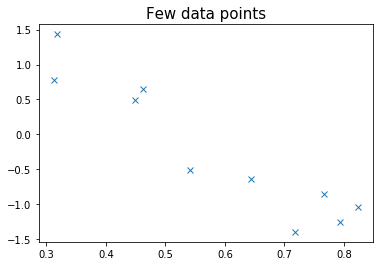

In [8]:
#gen_order = 3#1,2,3
X_data , Y_data = generate_data()
X_train,Y_train,X_test,Y_test = split_data(X_data,Y_data)
plot(X_train[0:10],Y_train[0:10],'Few data points')

#post_mean,post_cov,X = fit(X_train,Y_train,fit_order,prior_mean,prior_var,prior_cov,like_var,like_precision,True)

## log of the marginal   likelihood is calculated as below


### 1. $\log p(\textbf{t}|\alpha,\beta) = \frac{M}{2}\log \alpha + \frac{N}{2} \log \beta -E(m_N) -\frac{1}{2}\log|A| -\frac{N}{2} \log(2 \pi)$

where  $E(m_N) = \frac{\beta}{2} ||\textbf{t} - X^T m_N||^2 + \frac{\alpha}{2} m^{T}_N m_N$                           
       $m_N = \beta A^{-1} X^T \textbf{t}$ posterior mean                                                              
       $\alpha , \beta , A^{-1} $are prior precision , likelihood precision, posterior variance                                                        
       
       
       
       


In [9]:
def E(m,t,X,alpha,beta):
    
    L = np.power(t - np.matmul(X.transpose(),m),2)
    L = np.sum(L)
    L = np.power(L,2)*beta/2.0
    return L + alpha/2.0 * np.sum(m*m)

def compute_marginal_likelihood(Order,alpha,beta,post_mean,A,t,X):#order, prior precision, likelihood precision,post_mean, inverse_of_post_cov 
    N = t.shape[0]
    ml = Order/2.0 * np.log(alpha) + N/2.0 * np.log(beta)
    ml += - E(post_mean,t,X,alpha,beta) -1/2.0*np.log(np.linalg.det(A))
    ml += - N/2.0 * np.log(2*np.pi)
    return   ml
    

3
[-26033844.4831869, -15671003.16335654, -4603981.121745161]


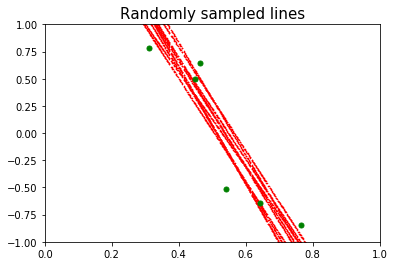

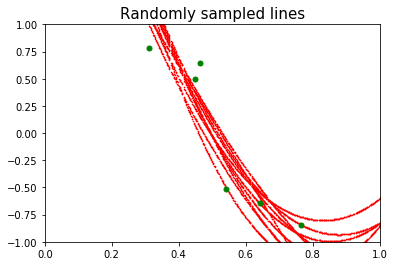

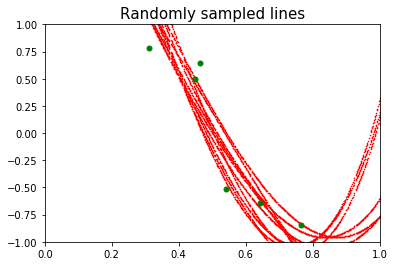

In [10]:
ml = []
for fit_order in range(1,4):
    prior_mean = np.zeros((fit_order+1,))
    prior_prec = 0.005 #alpha
    prior_cov = np.eye(fit_order+1,fit_order+1) * (1/prior_prec)
    like_std = 0.3
    like_precision = np.power(1/like_std,2) #beta
    post_mean,post_cov,X = fit(X_train,Y_train,fit_order,prior_mean,prior_cov,like_std,like_precision,True)
    ml.append(compute_marginal_likelihood(fit_order,prior_prec,like_precision,post_mean,np.linalg.inv(post_cov),Y_train,X))
print(np.argmax(ml)+1)
print(ml)

In [10]:
ml

[-1957530.0092516143,
 -740869.1544252824,
 -397727.9686298057,
 -442185.73017510516,
 -425274.5550285084,
 -335312.43052477745,
 -263839.6763893298,
 -226857.7923512615,
 -210681.21264995442]